In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil.relativedelta import relativedelta
from scipy.stats import loguniform
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('ggplot')

In [52]:
df = pd.read_csv('data.csv', parse_dates=[1]).sort_values(by = "date")
df['date'] = df['date'].dt.to_period('M')
df = df[277:].reset_index(drop=True)

In [4]:
# For testing
# df = df[df['date'] < '2008-01']

In [5]:
df.head()

,optid,date,secid,cp_flag,strike,bid,ask,volume,openint,impvol,...,vix,dhedged_return_mid,dhedged_return_spot,dhedged_return_spot_gamma,dhedged_return_mid_delev,dhedged_return_spot_delev,dhedged_return_spot_gamma_delev,IV_mness_deriv_1,IV_ttm_deriv_1,short_rate
0,10758593,1996-03,108105,C,630.0,20.000,20.500,7.0,2885.0,0.163628,...,16.54,-0.162051,-0.005116,-0.453583,-0.007654,-0.000242,-0.021423,-0.034178,0.000045,0.054624
1,10093854,1996-03,108105,P,650.0,17.500,18.250,126.0,2383.0,0.143119,...,16.54,-0.161114,-0.004490,-0.430225,-0.008292,-0.000231,-0.022141,-0.025132,0.000005,0.054624
2,10453184,1996-03,108105,P,675.0,33.625,34.625,0.0,202.0,0.133780,...,16.54,-0.032381,-0.001723,-0.212260,-0.002190,-0.000117,-0.014357,-0.008622,-0.000010,0.054624
3,11075738,1996-03,108105,P,650.0,35.000,36.500,13.0,2376.0,0.153038,...,16.54,-0.034062,-0.001898,-0.684611,-0.005364,-0.000299,-0.107810,-0.029598,0.000015,0.054624
4,11727207,1996-03,108105,C,655.0,30.250,31.250,7120.0,8000.0,0.146335,...,16.54,-0.019832,-0.000951,-0.160711,-0.001621,-0.000078,-0.013133,NaN,NaN,0.054624


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180537 entries, 0 to 180536
Data columns (total 37 columns):
 #   Column                           Non-Null Count   Dtype    
---  ------                           --------------   -----    
 0   optid                            180537 non-null  int64    
 1   date                             180537 non-null  period[M]
 2   secid                            180537 non-null  int64    
 3   cp_flag                          180537 non-null  object   
 4   strike                           180537 non-null  float64  
 5   bid                              180537 non-null  float64  
 6   ask                              180537 non-null  float64  
 7   volume                           180537 non-null  float64  
 8   openint                          180537 non-null  float64  
 9   impvol                           180537 non-null  float64  
 10  delta                            180537 non-null  float64  
 11  gamma                            180537

In [7]:
def get_summary(df_col):
    print(f'\nSummary of {df_col.name}:')
    print(f'Mean: {np.round( df_col.mean(),2)}')
    print(f'Median: {np.round( df_col.median(),2)}')
    print(f'Standard deviation: {np.round( df_col.std(),2)}')
    print(f'Number of observations: {np.round( df_col.count(),2)}')    

In [8]:
def add_months(date ,period_to_add=1):
    return (datetime.strptime(date, '%Y-%m') + relativedelta(months=period_to_add)).strftime('%Y-%m')

In [9]:
features = [ 'midprice', 'mness', 'ttm', 'embed_lev', 'impvol', 'gamma', 'vega', 'theta']

In [10]:
print('\nSummary statistics for Call options\n')
df[df["cp_flag"] == 'C'][features].apply(lambda x: get_summary(x), axis=0);


Summary statistics for Call options


Summary of midprice:
Mean: 91.46
Median: 37.39
Standard deviation: 163.66
Number of observations: 69044

Summary of mness:
Mean: 0.49
Median: 0.31
Standard deviation: 1.3
Number of observations: 69044

Summary of ttm:
Mean: 208.87
Median: 91.0
Standard deviation: 224.3
Number of observations: 69044

Summary of embed_lev:
Mean: 22.17
Median: 14.24
Standard deviation: 21.85
Number of observations: 69044

Summary of impvol:
Mean: 0.21
Median: 0.18
Standard deviation: 0.15
Number of observations: 69044

Summary of gamma:
Mean: 0.0
Median: 0.0
Standard deviation: 0.0
Number of observations: 69044

Summary of vega:
Mean: 240.76
Median: 176.03
Standard deviation: 230.11
Number of observations: 69044

Summary of theta:
Mean: -56.13
Median: -43.84
Standard deviation: 51.24
Number of observations: 69044


In [11]:
print('\nSummary statistics for Put options\n')

df[df["cp_flag"] == 'P'][features].apply(lambda x: get_summary(x), axis=0);


Summary statistics for Put options


Summary of midprice:
Mean: 71.67
Median: 14.25
Standard deviation: 154.16
Number of observations: 111493

Summary of mness:
Mean: -0.9
Median: -1.03
Standard deviation: 1.43
Number of observations: 111493

Summary of ttm:
Mean: 202.65
Median: 91.0
Standard deviation: 222.21
Number of observations: 111493

Summary of embed_lev:
Mean: 14.65
Median: 11.78
Standard deviation: 10.6
Number of observations: 111493

Summary of impvol:
Mean: 0.3
Median: 0.26
Standard deviation: 0.18
Number of observations: 111493

Summary of gamma:
Mean: 0.0
Median: 0.0
Standard deviation: 0.0
Number of observations: 111493

Summary of vega:
Mean: 178.92
Median: 105.07
Standard deviation: 205.27
Number of observations: 111493

Summary of theta:
Mean: -49.22
Median: -36.21
Standard deviation: 49.53
Number of observations: 111493


In [12]:
features += ['strike', 'spot_close', 'divrate', 'vix', 'short_rate', 'delta', 'date'] #+ ['optid']
train_features = features[1:-1]

In [53]:
clear_df = df[features]

In [54]:
start_date = '2007-01'

y_prices = clear_df[clear_df['date'] > start_date]['midprice']
dates = [str(d) for d in df[df['date'] > start_date]['date'].unique()]

In [15]:
def get_splits(df, num=False):
    train_pc = 0.85

    df_len = df.shape[0]
    separator = int(np.floor(df_len*train_pc))
    rest = df_len - separator

    if num:
        return df[:separator], df[separator:]
    else:
        return np.append(np.ones(separator)*-1,np.zeros(rest))

## OLS Regression

In [16]:
ols_predictions = np.array([])
ols_r2_better = np.array([])

In [17]:
# OLS
for current_date in df[df['date'] > start_date]['date'].unique():
    
    x_train = clear_df[clear_df['date'] < current_date][train_features]
    y_train = clear_df[clear_df['date'] < current_date]['midprice']

    x_test = clear_df[clear_df['date'] == current_date][train_features]
    y_test = clear_df[clear_df['date'] == current_date]['midprice']
    
    ols = LinearRegression()
    ols.fit(x_train, y_train)
    
    y_pred = ols.predict(x_test)
    
    # Write predictions to array
    ols_predictions = np.append(ols_predictions, y_pred)
    
    # Write R^2 to array
    ols_r2_better = np.append(ols_r2_better, r2_score(y_test, y_pred))

In [18]:
print(f"R^2 for OLS: {np.round(r2_score(y_prices, ols_predictions), 3)}\n")
print(f"MSE for OLS: {np.round(mean_squared_error(y_prices, ols_predictions), 3)}")

R^2 for OLS: 0.329

MSE for OLS: 19784.398


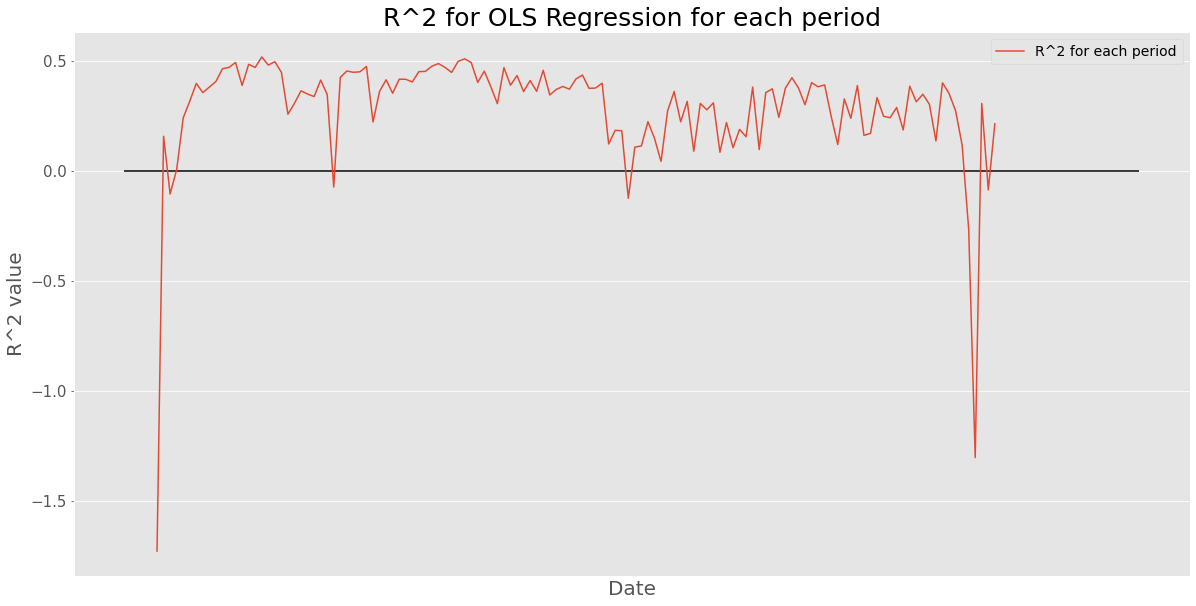

In [65]:
plt.plot(dates, ols_r2_better, label='R^2 for each period')
plt.ylabel('R^2 value', size=20)
plt.xlabel('Date', size=20)
plt.title('R^2 for OLS Regression for each period', size=25)
plt.legend(loc='upper right', fontsize=14)
plt.xticks([])
plt.hlines(y=0, xmin=-5, xmax=150, linestyles='solid', colors='black')

plt.savefig('ols_r2_better.png')

plt.show()

## Penalized Linear Regressions

### Ridge

In [20]:
ridge_predictions = np.array([])
ridge_r2_better = np.array([])

In [22]:
# Ridge
space = dict()

space['solver'] = ['auto','svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
space['alpha'] = np.array([10.0, 1.0, 0.1, 0.01, 0.001, 0])

for current_date in df[df['date'] > start_date]['date'].unique():
    temp = clear_df[clear_df['date'] < current_date]
    X, y = temp[train_features], temp['midprice']

    ps = PredefinedSplit(get_splits(temp))
    cv_scheme = list(ps.split())

    ridge = Ridge(fit_intercept=True, normalize=True)

    ridge_cv = GridSearchCV(ridge, param_grid=space, scoring='r2', cv = cv_scheme)

    ridge_cv.fit(X, y)
        
    x_test = clear_df[clear_df['date'] == current_date][train_features]
    y_test = clear_df[clear_df['date'] == current_date]['midprice']

    y_pred = ridge_cv.predict(x_test)

    # Write predictions to array
    ridge_predictions = np.append(ridge_predictions, y_pred)

    # Write R^2 to array    
    ridge_r2_better = np.append(ridge_r2_better, r2_score(y_test, y_pred))

In [23]:
print(f"R^2 for Ridge : {np.round(r2_score(y_prices, ridge_predictions), 3)}\n")
print(f"MSE for Ridge : {np.round(mean_squared_error(y_prices, ridge_predictions), 3)}")

R^2 for Ridge : 0.329

MSE for Ridge : 19767.075


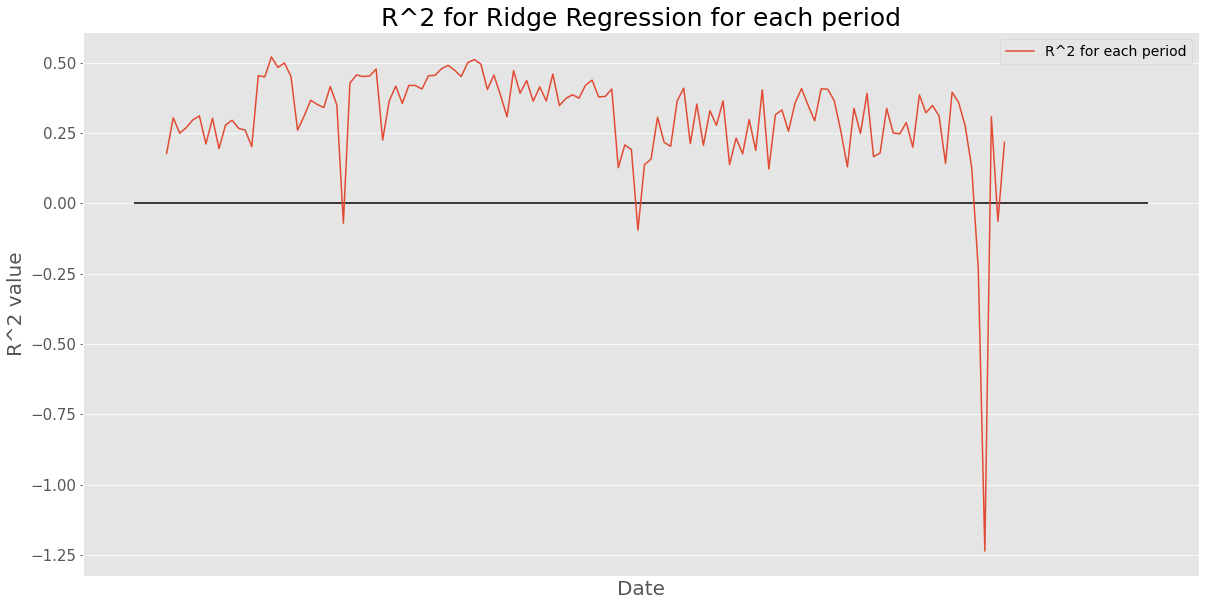

In [66]:
plt.plot(dates, ridge_r2_better, label='R^2 for each period')
plt.ylabel('R^2 value', size=20)
plt.xlabel('Date', size=20)
plt.title('R^2 for Ridge Regression for each period', size=25)
plt.legend(loc='upper right', fontsize=14)
plt.xticks([])
plt.hlines(y=0, xmin=-5, xmax=150, linestyles='solid', colors='black')
plt.savefig('ridge_r2_better.png')

plt.show()

### Lasso

In [25]:
lasso_predictions = np.array([])
lasso_r2_better = np.array([])

In [26]:
# Lasso
space = dict()

space['alpha'] = np.array([10.0, 1.0, 0.1, 0.01, 0.001])

for current_date in df[df['date'] > start_date]['date'].unique():
    temp = clear_df[clear_df['date'] < current_date]
    X, y = temp[train_features], temp['midprice']

    ps = PredefinedSplit(get_splits(temp))
    cv_scheme = list(ps.split())

    lasso = Lasso(fit_intercept=True, normalize=True)
    
    lasso_cv = GridSearchCV(lasso, param_grid=space, scoring='r2', cv = cv_scheme)
    
    lasso_cv.fit(X, y)
        
    x_test = clear_df[clear_df['date'] == current_date][train_features]
    y_test = clear_df[clear_df['date'] == current_date]['midprice']
    
    y_pred = lasso_cv.predict(x_test)
    
    # Write predictions to array
    lasso_predictions = np.append(lasso_predictions, y_pred)
    
    # Write R^2 to array
    lasso_r2_better = np.append(lasso_r2_better, r2_score(y_test, y_pred))

In [27]:
print(f"R^2 for Lasso : {np.round(r2_score(y_prices, lasso_predictions), 3)}\n")
print(f"MSE for Lasso : {np.round(mean_squared_error(y_prices, lasso_predictions), 3)}")

R^2 for Lasso : 0.326

MSE for Lasso : 19855.297


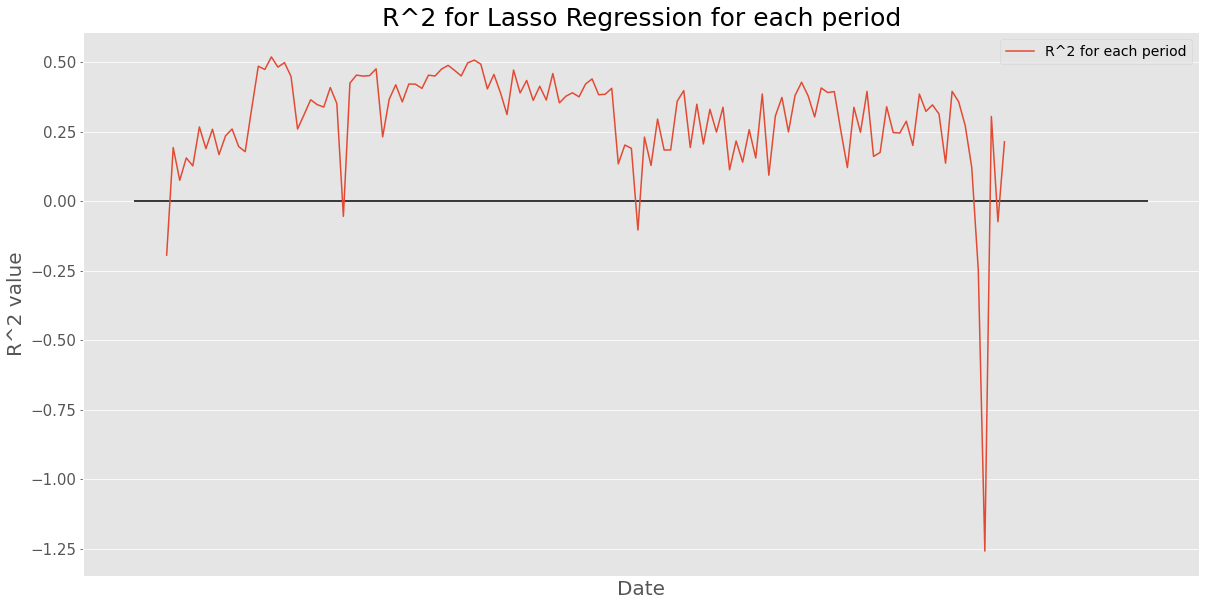

In [67]:
plt.plot(dates, lasso_r2_better, label='R^2 for each period')
plt.ylabel('R^2 value', size=20)
plt.xlabel('Date', size=20)
plt.title('R^2 for Lasso Regression for each period', size=25)
plt.legend(loc='upper right', fontsize=14)
plt.xticks([])
plt.hlines(y=0, xmin=-5, xmax=150, linestyles='solid', colors='black')
plt.savefig('lasso_r2_better.png')

plt.show()

### ElasticNet

In [29]:
elastic_net_predictions = np.array([])
elastic_net_r2_better = np.array([])

In [30]:
# ElasticNet
space = dict()

space['alpha'] = np.array([1.0, 0.01, 0.001, 0.0001])
space['l1_ratio'] = np.arange(0.95, 1, 0.005)

for current_date in df[df['date'] > start_date]['date'].unique():
    temp = clear_df[clear_df['date'] < current_date]
    X, y = temp[train_features], temp['midprice']

    ps = PredefinedSplit(get_splits(temp))
    cv_scheme = list(ps.split())
    
    elastic_net = ElasticNet(fit_intercept=True, normalize=True)
    
    elastic_net_cv = GridSearchCV(elastic_net, param_grid=space, scoring='r2', cv = cv_scheme)
    
    elastic_net_cv.fit(X, y)
    
    x_test = clear_df[clear_df['date'] == current_date][train_features]
    y_test = clear_df[clear_df['date'] == current_date]['midprice']
    
    y_pred = elastic_net_cv.predict(x_test)
    
    # Write predictions to array
    elastic_net_predictions = np.append(elastic_net_predictions, y_pred)
    
    # Write R^2 to array    
    elastic_net_r2_better = np.append(elastic_net_r2_better, r2_score(y_test, y_pred))

In [56]:
print(f"R^2 for OLS: {np.round(r2_score(y_prices, ols_predictions), 3)}")
print(f"MSE for OLS: {np.round(mean_squared_error(y_prices, ols_predictions), 3)}\n")

print(f"\nR^2 for Ridge : {np.round(r2_score(y_prices, ridge_predictions), 3)}")
print(f"MSE for Ridge : {np.round(mean_squared_error(y_prices, ridge_predictions), 3)}\n")

print(f"\nR^2 for Lasso : {np.round(r2_score(y_prices, lasso_predictions), 3)}")
print(f"MSE for Lasso : {np.round(mean_squared_error(y_prices, lasso_predictions), 3)}\n")

print(f"\nR^2 for Elastic Net: {np.round(r2_score(y_prices, elastic_net_predictions), 3)}")
print(f"MSE for Elastic Net: {np.round(mean_squared_error(y_prices, elastic_net_predictions), 3)}")

R^2 for OLS: 0.329
MSE for OLS: 19784.398


R^2 for Ridge : 0.329
MSE for Ridge : 19767.075


R^2 for Lasso : 0.326
MSE for Lasso : 19855.297


R^2 for Elastic Net: 0.325
MSE for Elastic Net: 19878.861


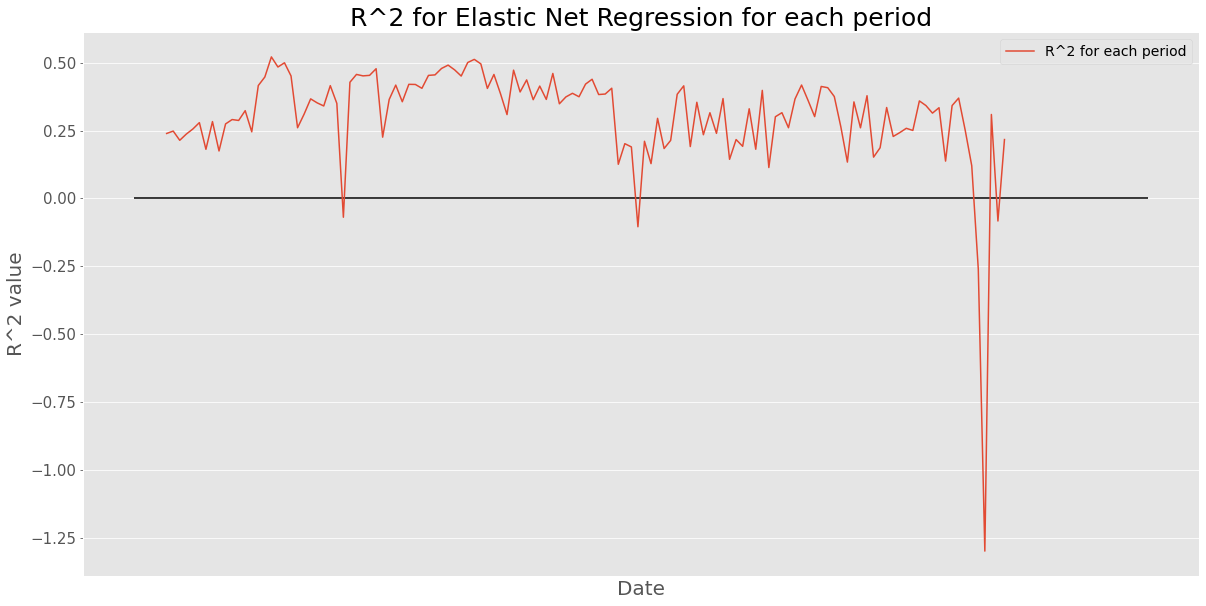

In [68]:
plt.plot(dates, elastic_net_r2_better, label='R^2 for each period')
plt.ylabel('R^2 value', size=20)
plt.xlabel('Date', size=20)
plt.title('R^2 for Elastic Net Regression for each period', size=25)
plt.legend(loc='upper right', fontsize=14)
plt.xticks([])
plt.hlines(y=0, xmin=-5, xmax=150, linestyles='solid', colors='black')
plt.savefig('elastic_net_r2_better.png')

plt.show()



## Put-Call Separation

In [69]:
df = pd.read_csv('total_df.csv', parse_dates=[15]).sort_values(by = "date")
df['date'] = df['date'].dt.to_period('M')
df = df[277:].reset_index(drop=True)

In [34]:
# For testing
# df = df[df['date'] < '2008-01']

In [70]:
clear_df = df[features]
start_date = '2007-01'

y_prices = clear_df[clear_df['date'] > start_date]['midprice']
dates = [str(d) for d in df[df['date'] > start_date]['date'].unique()]

## OLS Regression

In [36]:
ols_sep_predictions = np.array([])
ols_sep_r_2 = np.array([])

In [37]:
# OLS
for current_date in df[df['date'] > start_date]['date'].unique():
    
    x_train = clear_df[clear_df['date'] < current_date][train_features]
    y_train = clear_df[clear_df['date'] < current_date]['midprice']

    x_test = clear_df[clear_df['date'] == current_date][train_features]
    y_test = clear_df[clear_df['date'] == current_date]['midprice']
    
    ols = LinearRegression()
    ols.fit(x_train, y_train)
    
    y_pred = ols.predict(x_test)
    
    # Write predictions to array
    ols_sep_predictions = np.append(ols_sep_predictions, y_pred)
    
    # Write R^2 to array
    ols_sep_r_2 = np.append(ols_sep_r_2, r2_score(y_test, y_pred))

In [38]:
print(f"R^2 for OLS (Separation Put/Call): {np.round(r2_score(y_prices, ols_sep_predictions), 3)}\n")
print(f"MSE for OLS (Separation Put/Call): {np.round(mean_squared_error(y_prices, ols_sep_predictions), 3)}")

R^2 for OLS (Separation Put/Call): 0.329

MSE for OLS (Separation Put/Call): 19784.398


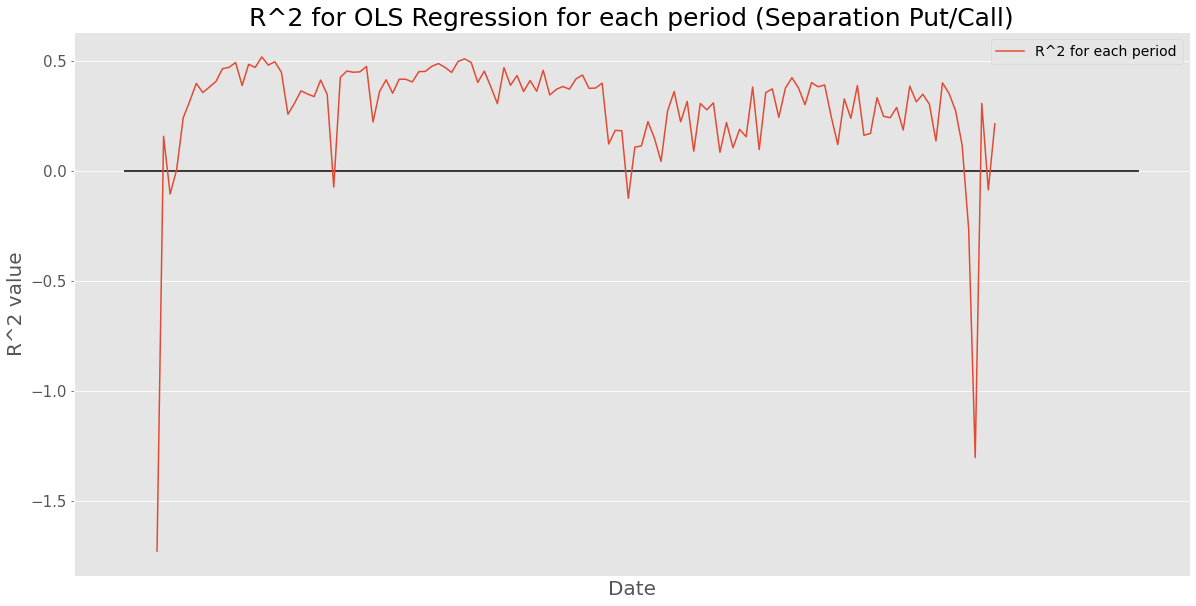

In [71]:
plt.plot(dates, ols_sep_r_2, label='R^2 for each period')
plt.ylabel('R^2 value', size=20)
plt.xlabel('Date', size=20)
plt.title('R^2 for OLS Regression for each period (Separation Put/Call)', size=25)
plt.legend(loc='upper right', fontsize=14)
plt.xticks([])
plt.hlines(y=0, xmin=-5, xmax=150, linestyles='solid', colors='black')
plt.savefig('ols_sep_r_2.png')

plt.show()

## Penalized Linear Regressions

### Ridge

In [40]:
ridge_sep_predictions = np.array([])
ridge_sep_r_2 = np.array([])

In [41]:
# Ridge
space = dict()

space['solver'] = ['auto','svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
space['alpha'] = np.array([10.0, 1.0, 0.1, 0.01, 0.001, 0])

for current_date in df[df['date'] > start_date]['date'].unique():
    temp = clear_df[clear_df['date'] < current_date]
    X, y = temp[train_features], temp['midprice']

    ps = PredefinedSplit(get_splits(temp))
    cv_scheme = list(ps.split())

    ridge = Ridge(fit_intercept=True, normalize=True)

    ridge_cv = GridSearchCV(ridge, param_grid=space, scoring='r2', cv = cv_scheme)

    ridge_cv.fit(X, y)
    
    x_test = clear_df[clear_df['date'] == current_date][train_features]
    y_test = clear_df[clear_df['date'] == current_date]['midprice']

    y_pred = ridge_cv.predict(x_test)

    # Write predictions to array
    ridge_sep_predictions = np.append(ridge_sep_predictions, y_pred)

    # Write R^2 to array
    ridge_sep_r_2 = np.append(ridge_sep_r_2, r2_score(y_test, y_pred))

In [42]:
print(f"R^2 for Ridge (Separation Put/Call): {np.round(r2_score(y_prices, ridge_sep_predictions), 3)}\n")
print(f"MSE for Ridge (Separation Put/Call): {np.round(mean_squared_error(y_prices, ridge_sep_predictions), 3)}")

R^2 for Ridge (Separation Put/Call): 0.33

MSE for Ridge (Separation Put/Call): 19755.536


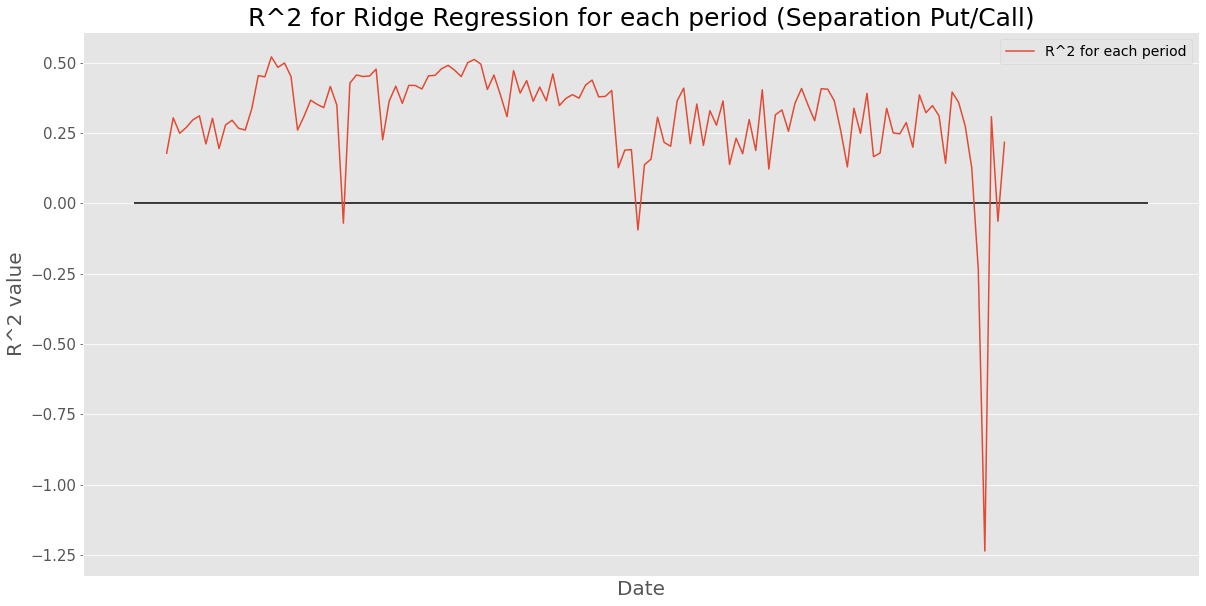

In [72]:
plt.plot(dates, ridge_sep_r_2, label='R^2 for each period')
plt.ylabel('R^2 value', size=20)
plt.xlabel('Date', size=20)
plt.title('R^2 for Ridge Regression for each period (Separation Put/Call)', size=25)
plt.legend(loc='upper right', fontsize=14)
plt.xticks([])
plt.hlines(y=0, xmin=-5, xmax=150, linestyles='solid', colors='black')
plt.savefig('ridge_sep_r_2.png')

plt.show()

### Lasso

In [44]:
lasso_sep_predictions = np.array([])
lasso_sep_r_2 = np.array([])

In [45]:
# Lasso
space = dict()

space['alpha'] = np.array([10.0, 1.0, 0.1, 0.01, 0.001])

for current_date in df[df['date'] > start_date]['date'].unique():
    temp = clear_df[clear_df['date'] < current_date]
    X, y = temp[train_features], temp['midprice']

    ps = PredefinedSplit(get_splits(temp))
    cv_scheme = list(ps.split())

    lasso = Lasso(fit_intercept=True, normalize=True)
    
    lasso_cv = GridSearchCV(lasso, param_grid=space, scoring='r2', cv = cv_scheme)
    
    lasso_cv.fit(X, y)
        
    x_test = clear_df[clear_df['date'] == current_date][train_features]
    y_test = clear_df[clear_df['date'] == current_date]['midprice']
    
    y_pred = lasso_cv.predict(x_test)
    
    # Write predictions to array
    lasso_sep_predictions = np.append(lasso_sep_predictions, y_pred)
    
    # Write R^2 to array
    lasso_sep_r_2 = np.append(lasso_sep_r_2, lasso_cv.score(X, y))

In [46]:
print(f"R^2 for Lasso (Separation Put/Call): {np.round(r2_score(y_prices, lasso_sep_predictions), 3)}\n")
print(f"MSE for Lasso (Separation Put/Call): {np.round(mean_squared_error(y_prices, lasso_sep_predictions), 3)}")

R^2 for Lasso (Separation Put/Call): 0.326

MSE for Lasso (Separation Put/Call): 19855.297


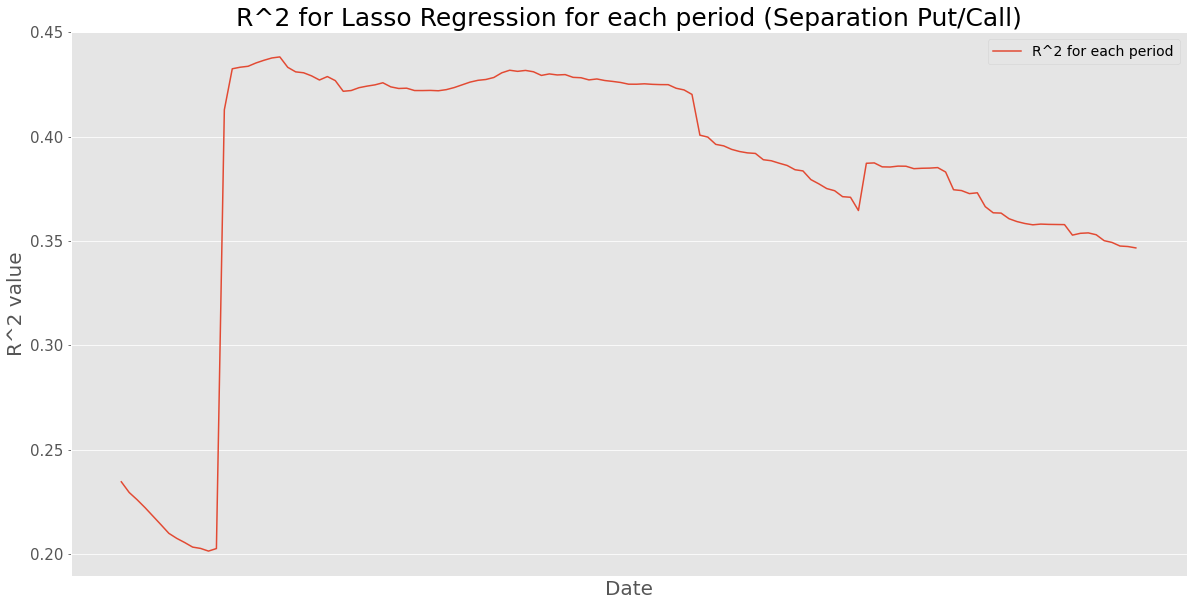

In [74]:
plt.plot(dates, lasso_sep_r_2, label='R^2 for each period')
plt.ylabel('R^2 value', size=20)
plt.xlabel('Date', size=20)
plt.title('R^2 for Lasso Regression for each period (Separation Put/Call)', size=25)
plt.legend(loc='upper right', fontsize=14)
plt.xticks([])
# plt.hlines(y=0, xmin=-5, xmax=150, linestyles='solid', colors='black')
# plt.savefig('lasso_sep_r_2.png')

plt.show()

### ElasticNet

In [48]:
elastic_net_sep_predictions = np.array([])
elastic_net_sep_r_2 = np.array([])

In [49]:
# ElasticNet
space = dict()

space['alpha'] = np.array([1.0, 0.01, 0.001, 0.0001])
space['l1_ratio'] = np.arange(0.95, 1, 0.005)

for current_date in df[df['date'] > start_date]['date'].unique():
    temp = clear_df[clear_df['date'] < current_date]
    X, y = temp[train_features], temp['midprice']

    ps = PredefinedSplit(get_splits(temp))
    cv_scheme = list(ps.split())
    
    elastic_net = ElasticNet(fit_intercept=True, normalize=True)
    
    elastic_net_cv = GridSearchCV(elastic_net, param_grid=space, scoring='r2', cv = cv_scheme)
    
    elastic_net_cv.fit(X, y)
    
    x_test = clear_df[clear_df['date'] == current_date][train_features]
    y_test = clear_df[clear_df['date'] == current_date]['midprice']
    
    y_pred = elastic_net_cv.predict(x_test)
    
    # Write predictions to array
    elastic_net_sep_predictions = np.append(elastic_net_sep_predictions, y_pred)
    
    # Write R^2 to array
    elastic_net_sep_r_2 = np.append(elastic_net_sep_r_2, r2_score(y_test, y_pred))

In [50]:
print(f"\nR^2 for OLS (Separation Put/Call): {np.round(r2_score(y_prices, ols_sep_predictions), 3)}")
print(f"MSE for OLS (Separation Put/Call): {np.round(mean_squared_error(y_prices, ols_sep_predictions), 3)}\n")

print(f"\nR^2 for Ridge (Separation Put/Call): {np.round(r2_score(y_prices, ridge_sep_predictions), 3)}")
print(f"MSE for Ridge (Separation Put/Call): {np.round(mean_squared_error(y_prices, ridge_sep_predictions), 3)}\n")

print(f"\nR^2 for Lasso (Separation Put/Call): {np.round(r2_score(y_prices, lasso_sep_predictions), 3)}")
print(f"MSE for Lasso (Separation Put/Call): {np.round(mean_squared_error(y_prices, lasso_sep_predictions), 3)}\n")

print(f"\nR^2 for Elastic Net (Separation Put/Call): {np.round(r2_score(y_prices, elastic_net_sep_predictions), 3)}")
print(f"MSE for Elastic Net (Separation Put/Call): {np.round(mean_squared_error(y_prices, elastic_net_sep_predictions), 3)}\n")

R^2 for OLS (Separation Put/Call): 0.329

MSE for OLS (Separation Put/Call): 19784.398
R^2 for Ridge (Separation Put/Call): 0.33

MSE for Ridge (Separation Put/Call): 19755.536
R^2 for Lasso (Separation Put/Call): 0.326

MSE for Lasso (Separation Put/Call): 19855.297
R^2 for Elastic Net (Separation Put/Call): 0.325

MSE for Elastic Net (Separation Put/Call): 19887.068


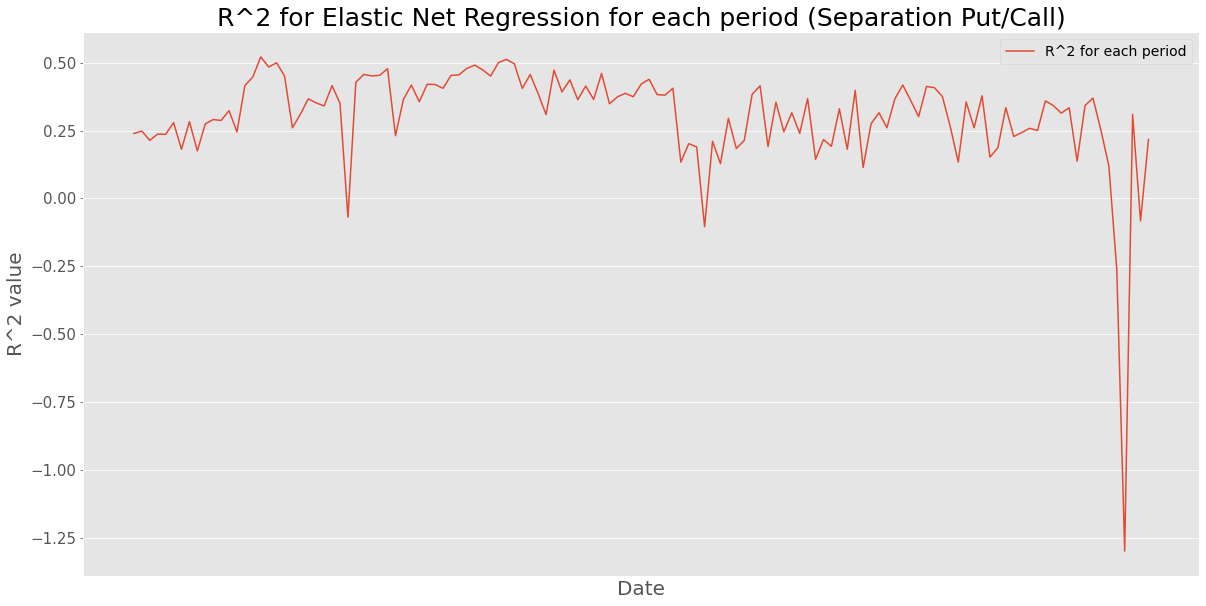

In [51]:
plt.plot(dates, elastic_net_sep_r_2, label='R^2 for each period')
plt.ylabel('R^2 value', size=20)
plt.xlabel('Date', size=20)
plt.title('R^2 for Elastic Net Regression for each period (Separation Put/Call)', size=25)
plt.legend(loc='upper right', fontsize=14)
plt.xticks([])
plt.hlines(y=0, xmin=-5, xmax=150, linestyles='solid', colors='black')

plt.show()